# Activation functions

<img src='images/non_linear.jpg' width='300' height='300'>

Some personal notes on different activation functions and parameter initialization to develop my intuition. I will be adding more content to this as I go along.

#### What are activation functions 

Activation functions apply a **non-linear** transformation to the linear output Z = SUM(WX + b)* of a single node in a neural network, such that Activation = g(Z). 

#### Why non-linear activation functions

Without non-linear activation functions, a multi-layer neural network would just behave like a simple **linear** regressor or classifier and would not be able to learn very complex functions to fit the data. If we image a neural net without non-linear transformations, we can state the following:
- The linear output of layer [l] can be written as Z[l] = SUM(W[l]Z[l-1] + b[l]), where Z[l-1] is the linear output of the previous layer
- Z[l-1] itself is equal to SUM(W[l-1]Z[l-2] + b[l-1]), which can be continued all the way to the input array X 
- Thus, in each layer, we multiply the result of the previous layer by some constant (W) and add some constant (b). In other words, the linear output Z of any layer can be written as X multiplied by a chain of constants, which is nothing else than multiplying X by a single constant (which is a simple linear regression)

<br/>
* WX here describes the dot product of the matrices W and X (where X represents the activation of the previous layer or simply the input array) 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# set style for seaborn charts 
sns.set_style("whitegrid")
%matplotlib inline

# switch off deprecation warnings
import warnings
warnings.filterwarnings("ignore")

### Write forward pass illustration function
- The following code will help illustrate the effect of various activation functions on the activations in a fully connected network (and the potential problems that may arise). The code produces random Gaussian inputs and forward propagates it through 10 layers with a chosen activation function. Activations in each layer are cached to visualize their statistics. 
- The snippet is based on lecture 5 of Stanford's "CS231n" course of 2016 on neural networks (with some of my adjustments and additions) 

In [2]:
# create simple forward pass function 
def forward_pass(activation_function, init_parameter=0.01):
    """
    Arguments:
        activation_function -- 'sigmoid', 'tanh', 'relu', 'leaky_relu', 'softplus', 'elu', 'swish'
        init_parameter -- parameter to be multiplied with the zero-centered Gaussian random normal 
                          distribution that initializes the weights W 
    Retuns: 
        cache of activations for each layer 
    """
    # create Gaussian random input with 1000 samples of 500 features 
    X = np.random.randn(500, 1000)

    # define shape for 10 layers as having 500 neurons each 
    hidden_layer_size = [500] * 10

    # define dict of possible activation functions to call. They are defined in this notebook  
    activation_functions = {'sigmoid': sigmoid, 'tanh': tanh, 'relu': relu, 'leaky_relu': leaky_relu, 'softplus': softplus,
                           'elu': elu, 'swish': swish}

    # create dictionary to cache activation values for each layer in the forward pass 
    activation_cache = {}

    # loop through all layers 
    for i in range(len(hidden_layer_size)):
        # set input for next layer as that of the pevious layer 
        if i == 0: 
            previous_layer_activation = X 
        else: 
            previous_layer_activation = activation_cache[i-1]

        # find shape of parameter array at current layer 
        in_shape = previous_layer_activation.shape[0]
        out_shape = hidden_layer_size[i]

        # initialize weights 
        W = np.random.randn(out_shape, in_shape) * init_parameter
 
        # calculate linear forward output of layer 
        Z = np.dot(W, previous_layer_activation)
         
        # calculate non-linear output (activation)
        A = activation_functions[activation_function](Z)
  
        # cache activations
        activation_cache[i] = A 
        
    return activation_cache 

# plot mean and standard deviation of layers from simple forward pass 
def plot_stats(cache): 
    df = pd.DataFrame()
    for i in range(len(cache)): 
        df_temp = pd.DataFrame({'mean': np.mean(cache[i]).ravel(), 'std': np.std(cache[i]).ravel(), 'layer': i})
        df = pd.concat([df, df_temp]) 

    fig, ax =plt.subplots(1,2, figsize=(15,5))
    sns.lineplot(x='layer', y='mean', data=df, ax=ax[0], label='activations mean')
    sns.lineplot(x='layer', y='std', data=df, ax=ax[1], label='activations standard deviation', color="r")
    fig.show()

# plot histogram of distriution of activations per layer from simple forward pass 
def plot_hist(cache): 
    df = pd.DataFrame()
    for i in range(len(cache)):
        df_temp = pd.DataFrame({'activations': cache[i].ravel(), 'layer': i})
        df = pd.concat([df, df_temp])
    # bring all plots onto one chart with 5 charts per row 
    chart = sns.FacetGrid(df, col="layer", col_wrap=5)
    chart.map(sns.distplot, 'activations', bins=np.arange(-1.1,1.1,0.05), kde=False)

## Sigmoid

The Sigmoid activation function "squashes" numbers into the range 0-1

<img src='images/Sigmoid.jpg' width='300' height='300'>

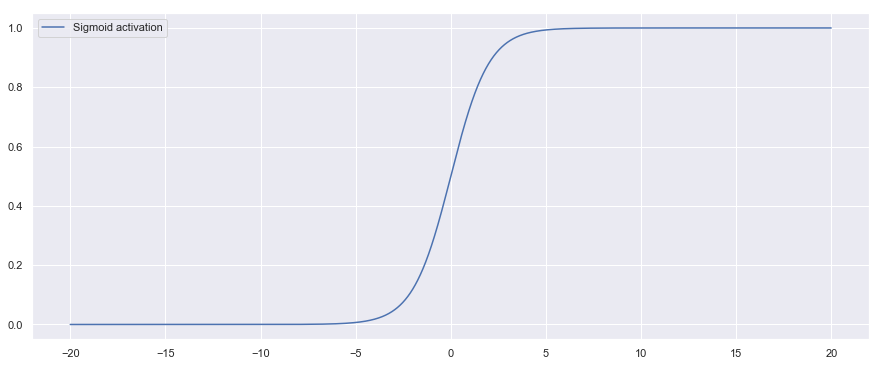

In [7]:
# plot dataset
sns.set(rc={'figure.figsize':(15,6)})
sns.lineplot(x=z, y=a, label='Sigmoid activation')

### Advantages 
- **Smooth and continuous out:** Well defined gradients for any input value (function is smooth and continuous)
- **Output can be interpreted as probability:** Useful for output layer for binary classification tasks
    
### Disadvantages
- **Vanishing gradients:** With small and large inputs, the curve of a Sigmoid becomes almost flat, so its derivative becomes almost zero. Since parameters during learning are generally updated as **<parameter(t+1) = parameter(t) * -partial derivative of parameter(t)>**, learning becomes very slow (the problem of **"vanishing gradients"**). This is expecially true for **deep networks**, because the chain rule makes sure that if one gradient becomes pratcially zero, all other gradients in layers before that practically disappear. This is because gradients of deeper layers are used as product input to compute gradients of shallower layers input during backpropagation 
- **Non-zero centered:** The outputs of a Sigmoid is non-zero centered (i.e., an input value of 0 produces an output value of 0.5). If the first layer produces only positive outputs, then the second layer will receive only positive inputs. During one backward pass, this restricts all parameters W to be either all increased or all decreased (but never allow some to increase and some to decrease). This slows down overall learning (see next section for more detailed explanation)
- **Numeric instabilities:** In order to minimize binary classification loss with a Sigmoid, output values need to approach the two extremes 0 and 1. To do so, input values need to approach positive and negative infinity, which also pushes weights to assume very large values. This can be countered by e.g., L1 or L2 regularization
- **Computationally expensive:** The exponential term is expensive to compute (relative to other activation functions)

In [8]:
# define function
def sigmoid(Z):
    return 1/(1+np.exp(-Z))
            
# create dataset and compute activation
z = np.arange(-20, 20, 0.01)
a = sigmoid(z)

### The issue of non-zero centered activation functions (e.g., Sigmoid): 

As can be seen from the below plots of a 10 layer fully connected forward pass with Sigmoid activation functions, the activations **cluster tightly around the mean of 0.5...**

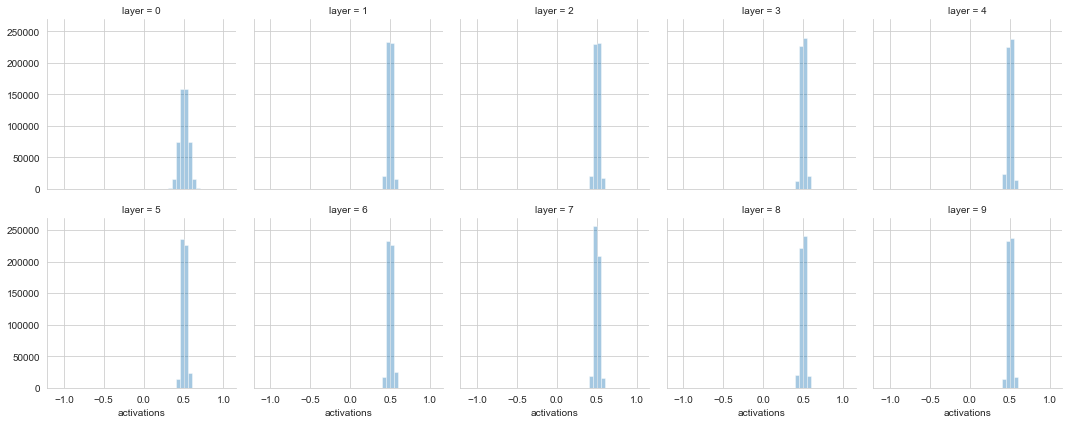

In [340]:
cache = forward_pass('sigmoid', init_parameter=0.01)
plot_hist(cache)

If we take a look at a generic final layer forward- and backward pass below, we observe the following: 
- The **loss** depends on the output of the **final layer activation** (a, also written as ŷ). 
- a is a function of the activation function g (in this case a Sigmoid), which is a function of the linear output z, which is a function of all the input values x(i) for that layer as well as the parameters w(i) and b)
- Using the chain rule, we can calculate the derivative of the loss function with respect to the parameters W, to update them accordingly 
- However, since **dz/dw(i) == x(i) and x(i) is always positive using Sigmoid, dloss/dw is either positive for all w(i) or negative for all w(i) depending on the single value dloss/dz** 
- Thus, the single value dloss/dz determines the sign of all values dz/dw(i) and thus allow the network to either increase or decrease all values of W, but never to increase some and decrease some. This slows down convergence 

<img src='images/Non_zero_mean.jpg' width='800' height='400'>

## tanh 
The tanh activation function "squashes" numbers into the range (-1 // +1) 

<img src='images/tanh.jpg' width='500' height='500'>



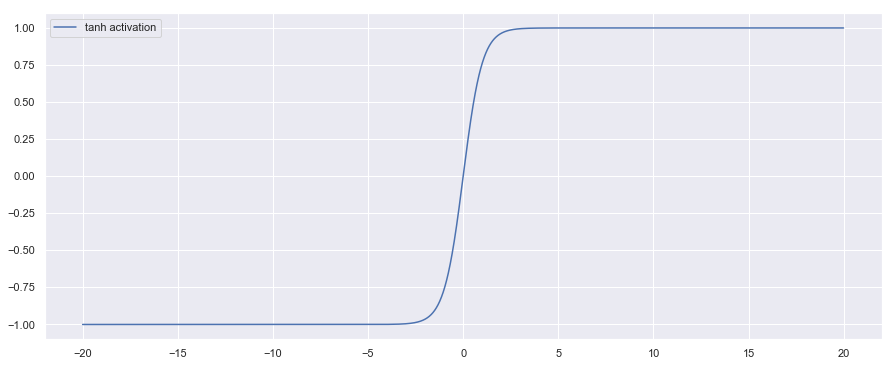

In [11]:
# plot dataset
sns.lineplot(x=z, y=a, label='tanh activation')


### Advantages 
- **Same as for Sigmoid:** However, other than the Sigmoid functions, the output of tanh is zero-centered and it is thus strictly better than Sigmoid

### DisadvantageS

- **Vanishing gradients:** Suffers from two cases of **vanishing gradients** (see next section)

In [10]:
# define function
def tanh(Z):
    return (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    
# create dataset and compute activation 
z = np.arange(-20, 20, 0.01)
a = tanh(z)

### The two cases of vanishing gradients 
- **Case 1**: vanishing gradients for large and small values of inputs -- this is trivial when looking at the shape of the tanh function which flattens out for large and small input values
- **Case 2**: the below charts of tanh activations statistics in a 10 layer forward propagation shows that activations cluster ever more tightly around the function mean of 0... 

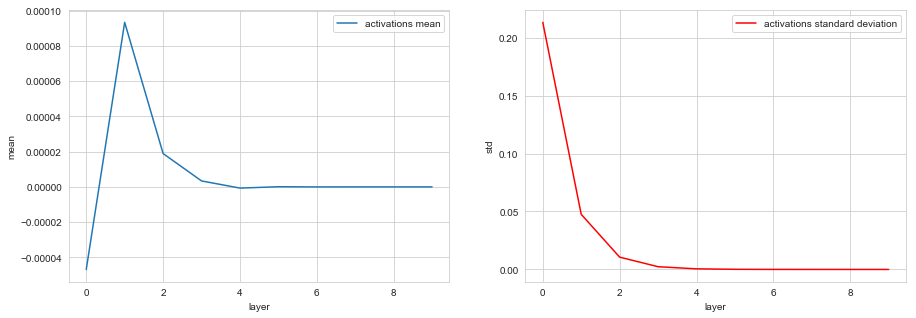

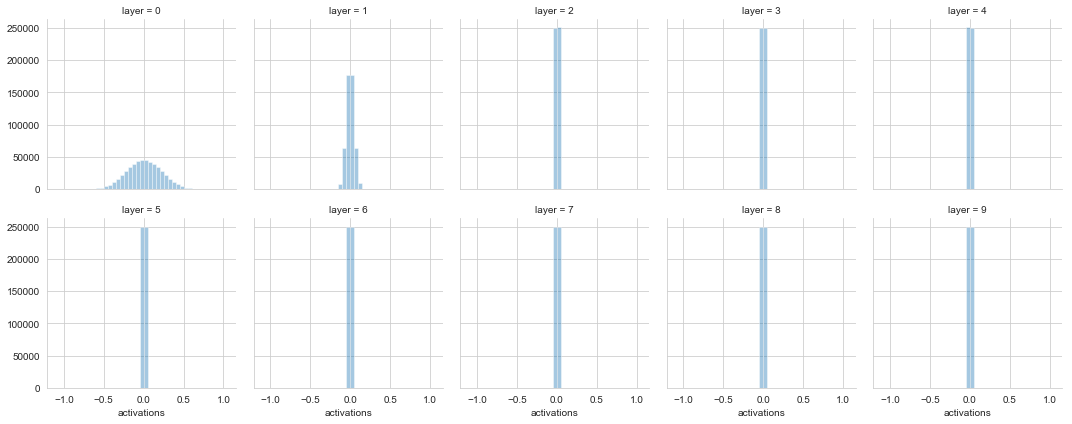

In [343]:
cache = forward_pass('tanh', init_parameter=0.01)
plot_stats(cache) 
plot_hist(cache)

**Case 2 continued**.. 

Since the derivative of the parameter W with respect to the loss function involves a **multiplication with the input X** (and the input X collapses towards zero), the **derivative of W collapses to 0 stopping all learning in the network (vanishing gradients)**

## ReLU (rectified linear unit)

The ReLU unit generally treats inputs depending on their range, i.e., it usually has a distinct function for input values larger/smaller than zero. In case of the standard ReLU function, this entails a slope of 0 for input values <0 and a slope of 1 for input values >0. A "leaky" ReLU function usually has a very small positive slope for all negative inputs.  

<img src='images/ReLU.jpg' width='500' height='500'>

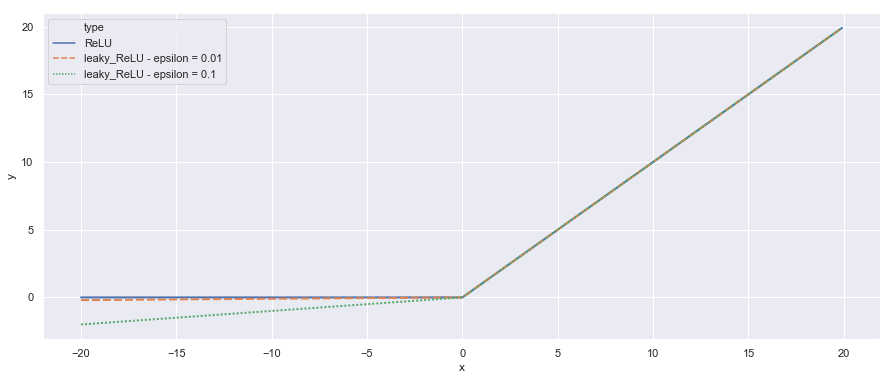

In [17]:
# plot dataframe
sns.lineplot(x='x', y='y', hue='type', style='type', data=df, lw=2)

### Advantages 
- **No vanishing gradients:** No vanishing gradients for positive values (i.e., there is always a distinct non-zero slope and thus learning can happen). Since z tends to become larger in deeper networks, this allows for training very deep neural networks (which makes it an attractive choice for image recognition tasks) 
- **Computationally cheap** 
    
    
### Disadvantages
- **Dying nodes:** For the standard ReLU, the activation and slopes are zero for negative inputs which prevents gradient updates. The chain rule makes sure that gradients will also be zero in the previous layers. If the activation for a neuron for all batches of data is <0, it is dead and will not update any more. This can happen because **weights were initialized in an "unlucky" way** (dead from the beginning) or happen randomly during the training, where with a high learning rate, the weights of a **neuron get updated by chance into a range that produces a zero activation** in the next run and thus "kills" the neuron. Any neuron that has ever been zero will remain so. One way to counter this: Initialize weights into a slightly positive range (i.e., multiply by 0.01)
- **Diminishing activations:** For leaky ReLUs, if the negative range slope is chosen to be between 0-1, activation values can quickly diminish for deeper networks (for units with negative z's)   
- **Non-zero centered:** See the discussion around this issue where the Sigmoid function is discussed above
- **Undefined gradient for zero inputs:** This problem can be avoided by simply assigned zero input value a specified output (e.g., zero) and slope (e.g., one)


In [18]:
# define ReLU 
def relu(Z):
    return np.maximum(0, Z)

# define leaky ReLU 
def leaky_relu(Z, epsilon=0.01):
    return np.where(Z > 0, Z, epsilon*Z)

# create dataset and compute activation
z = np.arange(-20, 20, 0.1)
a_01 = relu(z)
a_02 = leaky_relu(z, 0.01)
a_03 = leaky_relu(z, 0.1)

# combine data in pandas dataframe
df_01 = pd.DataFrame({'x': z, 'y': a_01, 'type':100}).replace(100, 'ReLU')
df_02 = pd.DataFrame({'x': z, 'y': a_02, 'type':100}).replace(100, 'leaky_ReLU - epsilon = 0.01')
df_03 = pd.DataFrame({'x': z, 'y': a_03, 'type':100}).replace(100, 'leaky_ReLU - epsilon = 0.1')
df = pd.concat([df_01, df_02, df_03])

Plotting the histogram for a ReLU output shows how a large portion of neurons are **immediately "killed" by falling into the <0 range**. As the network forward propagates, more and more neurons die as the **chance increases they get get multiplied by a negative value of W.** If we choose to initialize the values of W in a range that is more positive, then the average value of activations would start increasing for each additional layer (see chart after histogram)

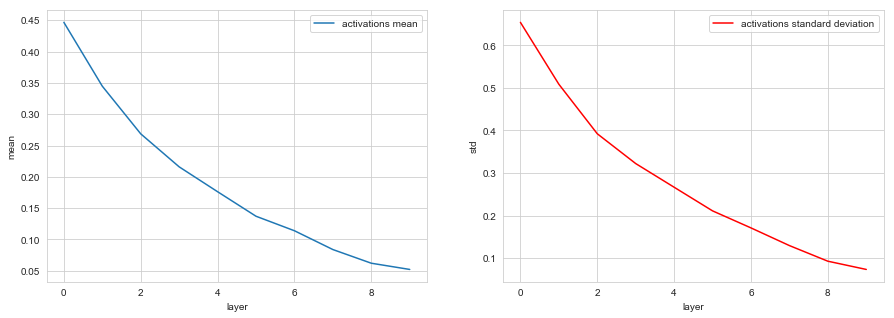

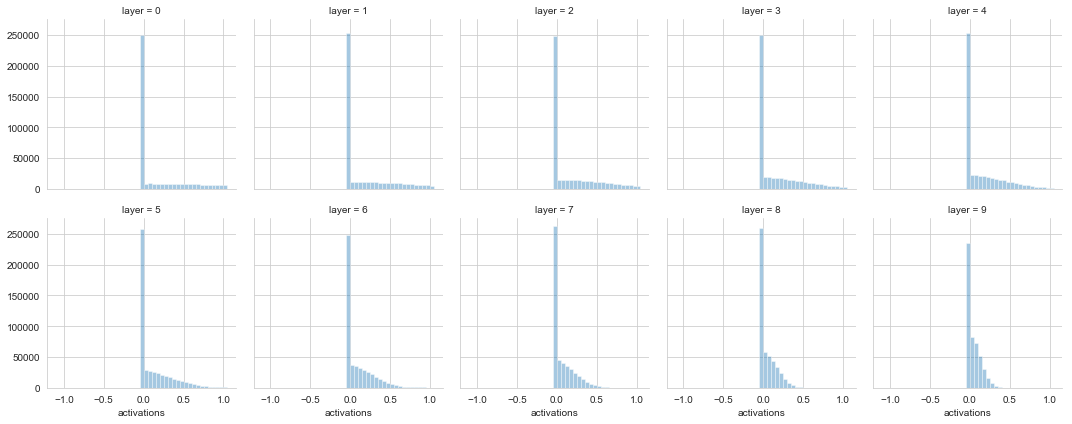

In [374]:
# neurons dying 
cache = forward_pass('relu', init_parameter=0.05)
plot_stats(cache)
plot_hist(cache)

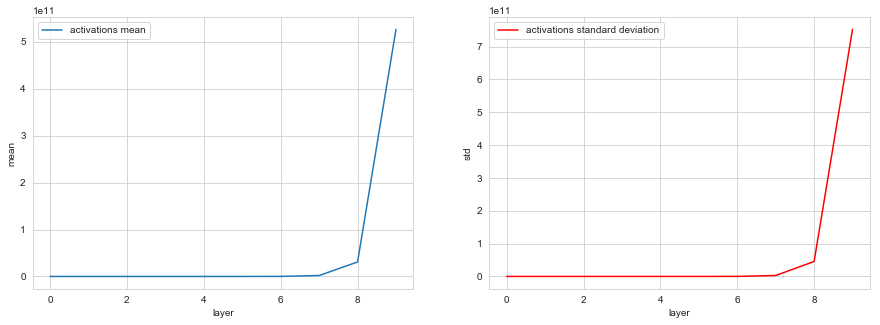

In [373]:
# neurons exploding
cache = forward_pass('relu', init_parameter=1)
plot_stats(cache)

## Softplus 

The Softplus activation function looks like a version of the ReLU function that is continously differentiable (i.e, does not have a "kink" at z=0). Interresingly, its derivative is the Sigmoid function 

<img src='images/Softplus.jpg' width='500' height='500'>

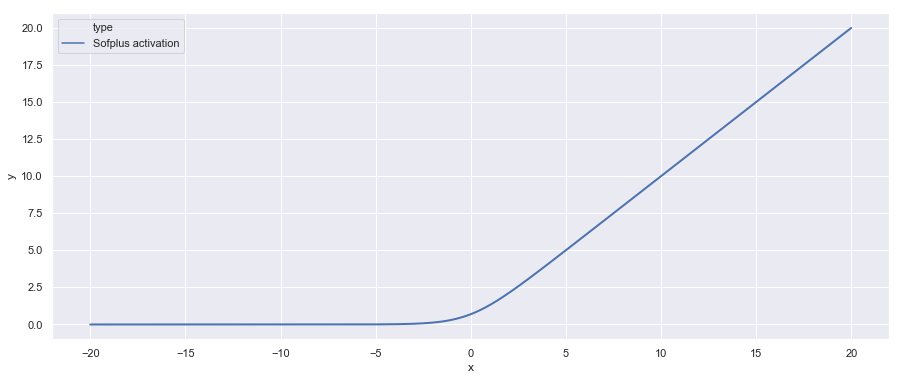

In [22]:
# plot dataframe
sns.lineplot(x='x', y='y', hue='type', style='type', data=df, lw=2)

### Advantage 
- **Continuous gradients:** Has a continuous derivative and covers at least a small range of negative z's with a meaningful gradient 

### Disadvantage
- **Computationally more expensive than ReLU** 

In [21]:
def softplus(z):
    return np.log(1+np.exp(z))

# create dataset 
z = np.arange(-20, 20, 0.01)
a = softplus(z)

# combine data in pandas dataframe
df = pd.DataFrame({'x': z, 'y': a, 'type':100}).replace(100, 'Sofplus activation')

## ELU (exponential linear unit) 
The ELU function resembles the ReLU function for positive inputs, but is exponentially shaped for negative inputs (where the exact shape depends on a hyperparameter alpha). Often used in image recognition (though less common than the standard ReLUs) 

<img src='images/ELU.jpg' width='500' height='500'>

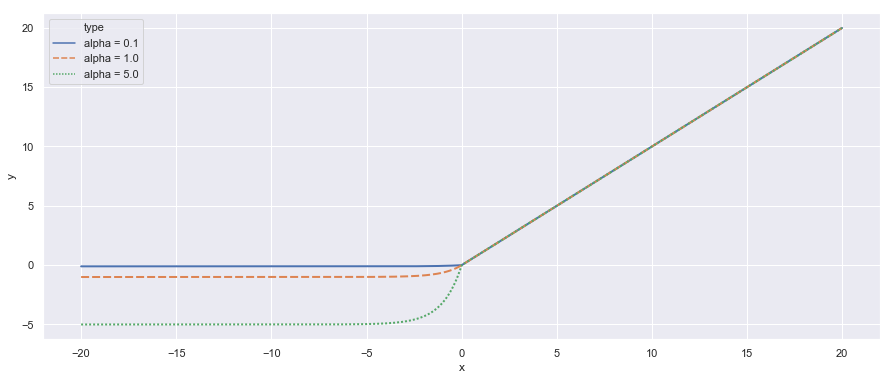

In [25]:
# plot dataframe
sns.lineplot(x='x', y='y', hue='type', style='type', data=df, lw=2)

### Advantage
- **More zero-centered than ReLU:** See discussion of issues caused by non-zero centered activation functions where Sigmoids are discussed in this notebook
    
### Disadvantage
- **Computationally more expensive than ReLUs**

In [24]:
def elu(Z, alpha=1):
    return np.where(Z > 0, Z, alpha*(np.exp(Z)-1))

# create dataset 
z = np.arange(-20, 20, 0.01)
a_01 = elu(z, 0.1)
a_02 = elu(z, 1)
a_03 = elu(z, 5)

# combine data in pandas dataframe
df_01 = pd.DataFrame({'x': z, 'y': a_01, 'type':100}).replace(100, 'alpha = 0.1')
df_02 = pd.DataFrame({'x': z, 'y': a_02, 'type':100}).replace(100, 'alpha = 1.0')
df_03 = pd.DataFrame({'x': z, 'y': a_03, 'type':100}).replace(100, 'alpha = 5.0')
df = pd.concat([df_01, df_02, df_03])

## Swish activation function

Multiplying Sigmoid(z) by z. Sometimes also introduces a parameter beta into the Sigmoid part of the function (see code below) 

<img src='images/Swish.jpg' width='500' height='500'>

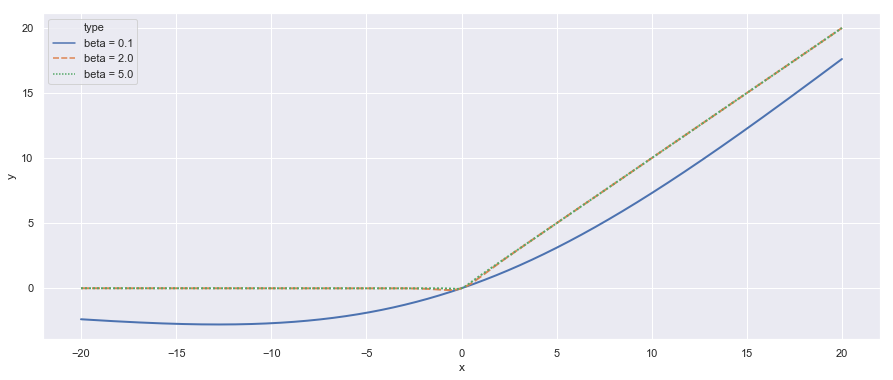

In [27]:
# plot dataframe
sns.lineplot(x='x', y='y', hue='type', style='type', data=df, lw=2)

### Advantages 
- **No diminshing gradients:** Avoids diminishing gradients for positive values of z (unlike Sigmoid) 
- **Has gradient for negative values of z:** Unlike the standard ReLU, it has gradients for negative values and seems to perform better than ReLU in deep neural networks
- **Well defined gradients for any input value:** Function is smooth and continuous

### Disadvantage
- **Computationally more expensive than ReLU**

In [26]:
def swish(z):
    return z/(1+np.exp(-z))

def swish_beta(z, beta=2): 
    return z/(1+np.exp(beta*-z))

# create dataset 
z = np.arange(-20, 20, 0.01)
a_01 = swish_beta(z, 0.1)
a_02 = swish_beta(z, 2)
a_03 = swish_beta(z, 5)

# combine data in pandas dataframe
df_01 = pd.DataFrame({'x': z, 'y': a_01, 'type':100}).replace(100, 'beta = 0.1')
df_02 = pd.DataFrame({'x': z, 'y': a_02, 'type':100}).replace(100, 'beta = 2.0')
df_03 = pd.DataFrame({'x': z, 'y': a_03, 'type':100}).replace(100, 'beta = 5.0')
df = pd.concat([df_01, df_02, df_03])

## Softmax

While the previous activation functions produce one output for one input, the softmax functions converts an array of inputs into an array of outputs of equal size. Crucially, it "squashes" all values into a range between 0-1 such that the sum total of all outputs == 1. This is handy when trying to predict multiple classes, as we can intepret the output as class probabilities. The plot at the end of this section shows how input labels (x-axis) are mapped onto the 0-1 range (y-axis)  

<img src='images/Softmax.jpg' width='500' height='500'>

The sum of all activations is 0.9999999999999998


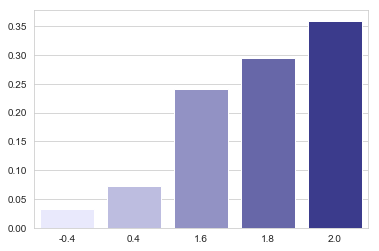

In [79]:
# softmax function 
def softmax(input_vector): 
    return np.exp(input_vector)/sum(np.exp(input_vector))


# generate data
input_vector = 2 * np.random.randn(5).round(1)

# get softmax output
activation = softmax(input_vector)

# check that sum of all activations == 1 
print("The sum of all activations is "+str(sum(activation)))